# TensorFlow2教程-CNN-RNN结构用于图像处理

## 1.导入数据
使用cifar-10数据集
![](https://image.slidesharecdn.com/pycon2015-150913033231-lva1-app6892/95/pycon-2015-48-638.jpg?cb=1442115225)

In [21]:
import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.utils import plot_model

In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    for gpu in gpus:
        print(gpu)
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [13]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [14]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [15]:
print(x_train.shape, ' ', y_train.shape)
print(x_test.shape, ' ', y_test.shape)

(50000, 32, 32, 3)   (50000, 10)
(10000, 32, 32, 3)   (10000, 10)


## 2.简单的cnn-rnn结构

In [25]:
from tensorflow.keras import layers
model = keras.Sequential()

In [26]:
x_shape = x_train.shape
model.add(layers.Conv2D(input_shape=(x_shape[1], x_shape[2], x_shape[3]),
                       filters=32, kernel_size=(3,3), strides=(1,1), 
                       padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

In [27]:
print(model.output_shape)

(None, 16, 16, 32)


In [28]:
model.add(layers.Reshape(target_shape=(16*16, 32)))
model.add(layers.LSTM(50, return_sequences=False))

model.add(layers.Dense(10, activation='softmax'))

In [29]:
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 256, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
Total params: 18,006
Trainable params: 18,006
Non-trainable params: 0
_________________________________________________________________


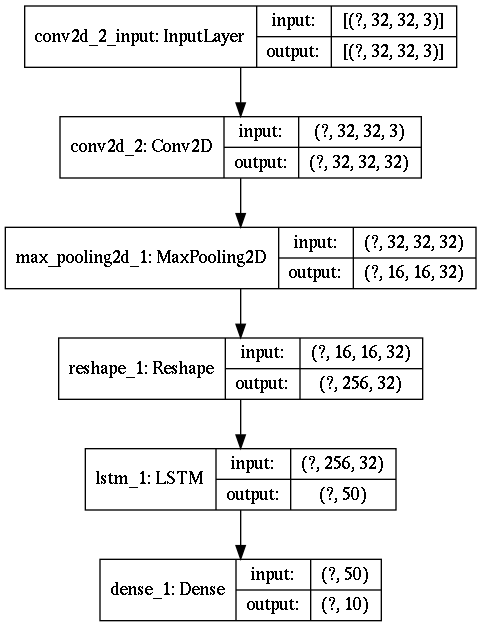

In [30]:
plot_model(model, show_shapes=True)

In [31]:
%%time
history = model.fit(x_train, y_train, batch_size=32,epochs=30, validation_split=0.1)


Train on 45000 samples, validate on 5000 samples
Epoch 1/30
45000/45000 [==============================] - 30s 659us/sample - loss: 2.1612 - accuracy: 0.1946 - val_loss: 2.0942 - val_accuracy: 0.2414
Epoch 2/30
45000/45000 [==============================] - 28s 622us/sample - loss: 1.9890 - accuracy: 0.2616 - val_loss: 1.8861 - val_accuracy: 0.2940
Epoch 3/30
45000/45000 [==============================] - 28s 627us/sample - loss: 1.8415 - accuracy: 0.3104 - val_loss: 1.7687 - val_accuracy: 0.3438
Epoch 4/30
45000/45000 [==============================] - 29s 635us/sample - loss: 1.7608 - accuracy: 0.3444 - val_loss: 1.6897 - val_accuracy: 0.3652
Epoch 5/30
45000/45000 [==============================] - 29s 646us/sample - loss: 1.6940 - accuracy: 0.3712 - val_loss: 1.6581 - val_accuracy: 0.3732
Epoch 6/30
45000/45000 [==============================] - 29s 649us/sample - loss: 1.6431 - accuracy: 0.3885 - val_loss: 1.5781 - val_accuracy: 0.4192
Epoch 7/30
45000/45000 [=====================

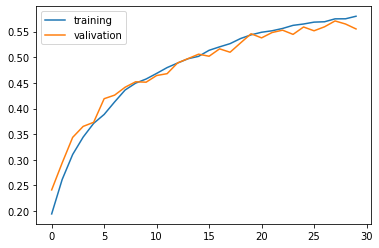

In [32]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'valivation'], loc='upper left')
plt.show()

In [33]:
res = model.evaluate(x_test,y_test)

10000/10000 [==============================] - 3s 311us/sample - loss: 1.2667 - accuracy: 0.5475


## CNN和LSTM结果合并

In [34]:
x_shape = x_train.shape
inn = layers.Input(shape=(x_shape[1], x_shape[2], x_shape[3]))
conv = layers.Conv2D(filters=32,kernel_size=(3,3), strides=(1,1),
                    padding='same', activation='relu')(inn)
pool = layers.MaxPool2D(pool_size=(2,2), padding='same')(conv)
flat = layers.Flatten()(pool)
dense1 = layers.Dense(64)(flat)

In [35]:
reshape = layers.Reshape(target_shape=(x_shape[1]*x_shape[2], x_shape[3]))(inn)
lstm_layer = layers.LSTM(32, return_sequences=False)(reshape)
dense2 = layers.Dense(64)(lstm_layer)


In [36]:
merged_layer = layers.concatenate([dense1, dense2])
outt = layers.Dense(10,activation='softmax')(merged_layer)
model = keras.Model(inputs=inn, outputs=outt)
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 1024, 3)      0           input_1[0][0]                    
______________________________________________________________________________________________

In [37]:
%%time
history2 = model.fit(x_train, y_train, batch_size=64,epochs=5, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/5
45000/45000 [==============================] - 46s 1ms/sample - loss: 14.7685 - accuracy: 0.2962 - val_loss: 1.8954 - val_accuracy: 0.3670
Epoch 2/5
45000/45000 [==============================] - 44s 979us/sample - loss: 1.7054 - accuracy: 0.4097 - val_loss: 1.7776 - val_accuracy: 0.4118
Epoch 3/5
45000/45000 [==============================] - 44s 975us/sample - loss: 1.5451 - accuracy: 0.4615 - val_loss: 1.7623 - val_accuracy: 0.4314
Epoch 4/5
45000/45000 [==============================] - 44s 979us/sample - loss: 1.4528 - accuracy: 0.4920 - val_loss: 1.7203 - val_accuracy: 0.4382
Epoch 5/5
45000/45000 [==============================] - 45s 992us/sample - loss: 1.4060 - accuracy: 0.5074 - val_loss: 1.7392 - val_accuracy: 0.4362
CPU times: user 2min 32s, sys: 26.7 s, total: 2min 59s
Wall time: 3min 43s


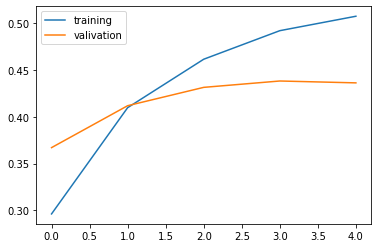

In [38]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.legend(['training', 'valivation'], loc='upper left')
plt.show()